# Analysis of results from Toloka survey

In [1]:
# Imports and installs
!pip3 install python-Levenshtein
!pip3 install seaborn
import pandas as pd
import numpy as np 
import datetime
import json
import Levenshtein
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# For JSON
from ast import literal_eval

# To be able to import from other notebook
!pip3 install nbimporter
import nbimporter
from extraction import extract_data

# Remove warning
pd.options.mode.chained_assignment = None

# For plotting
plt.rcParams['axes.facecolor']='white'  # to have white background
plt.rcParams['savefig.facecolor']='white'  # to have white background
hex1, hex2, hex3, hex4 = '#79ccb3', '#92cad1', '#e9724d', '#868686'
large_fontsize = 35
medium_fontsize = 25
small_fontsize = 15

raw = pd.read_json("data/kym.json")        # meme templates from Know Your Meme
events = pd.read_json("data/events.json")  # memes with timestamps from origin and spread
memes = extract_data(raw, events)

# Q1: Have you used this meme before?
# Q2: Have you seen others use this meme?
# Q3: Do you relate to this meme?

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

### Select relevant columns and clean data

In [2]:
results = pd.read_csv("data/toloka_results.tsv", sep="\t")
results = results.drop(columns=['INPUT:image', 'OUTPUT:captcha', 'OUTPUT:text_review_mode', 'GOLDEN:q1', 'GOLDEN:q2', 'GOLDEN:q3', 'GOLDEN:result', 'GOLDEN:captcha', 'GOLDEN:reaction', 'GOLDEN:snowclone', 'GOLDEN:exploitable', 'GOLDEN:text_review_mode', 'HINT:text', 'HINT:default_language', 'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status'])
results['OUTPUT:result'] = results['OUTPUT:result'].apply(lambda x: json.loads(x))

# Convert multiple-choice answers to boolean
results['OUTPUT:q1'] = results['OUTPUT:q1'].map({'1y': True, '1n': False})
results['OUTPUT:q2'] = results['OUTPUT:q2'].map({'2y': True, '2n': False})
results['OUTPUT:q3'] = results['OUTPUT:q3'].map({'3y': True, '3n': False})

# Calculate time taken per assignment
results['ASSIGNMENT:submitted'] = pd.to_datetime(results['ASSIGNMENT:submitted'])
results['ASSIGNMENT:started'] = pd.to_datetime(results['ASSIGNMENT:started'])
results['minutes_taken'] = results['ASSIGNMENT:submitted'] - results['ASSIGNMENT:started']
results['minutes_taken'] = results['minutes_taken'].apply(lambda x: round(x.total_seconds() / 60, 2))
results = results.drop(columns=['ASSIGNMENT:started', 'ASSIGNMENT:submitted'])

results.head()

,INPUT:input,INPUT:memelink,OUTPUT:q1,OUTPUT:q2,OUTPUT:q3,OUTPUT:result,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,minutes_taken
0,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching', '""autistic s...",False,True,False,8.59
1,"No Items, Fox Only, Final Destination is a cat...",https://knowyourmeme.com/memes/no-items-fox-on...,False,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...",True,False,False,5.60
2,Lie Down / Try Not to Cry / Cry a Lot refers a...,https://knowyourmeme.com/memes/lie-down-try-no...,False,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",True,False,False,2.71
3,Autistic Screeching is an exploitable comic se...,https://knowyourmeme.com/memes/autistic-screec...,False,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...",True,False,False,6.74
4,Y'all Consider This A Date? refers to a series...,https://knowyourmeme.com/memes/yall-consider-t...,False,False,False,"{'Title': ['Y'all Consider This A Date?'], 'Me...",False,False,True,9.53


## Time taken for annotation

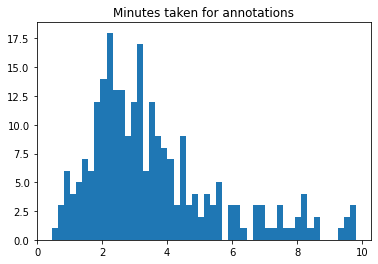

In [3]:
# Plot time taken for annotations (in minutes)
plt.hist(results['minutes_taken'], bins = 50)
# plt.bar(results['minutes_taken'], bins = len(results))
plt.title("Minutes taken for annotations")
plt.show()

## Analysis of multiple-choice answers

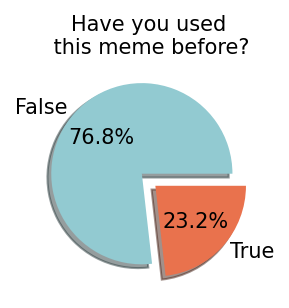

In [4]:
# Add year as separate column
from collections import Counter
plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 150

plot_data = Counter(results['OUTPUT:q1'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you used\n this meme before?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.set_size_inches(8, 6)
# plt.savefig('graphs/q1.png', bbox_inches='tight')
plt.show()

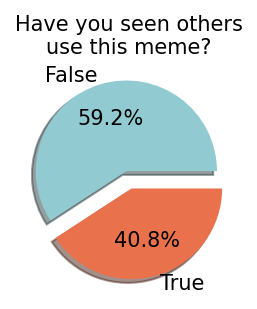

In [5]:
plot_data = Counter(results['OUTPUT:q2'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("Have you seen others\nuse this meme?", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/q2.png', bbox_inches='tight')
plt.show()

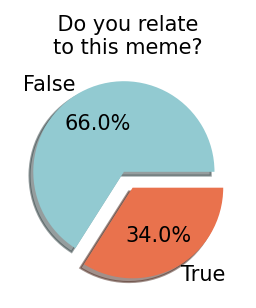

In [6]:
plot_data = Counter(results['OUTPUT:q3'])

plt.figure(figsize=(2, 2), dpi=150)
plt.pie(x = plot_data.values(), labels = plot_data.keys(), colors=[hex2, hex3], autopct='%1.1f%%', shadow=True, explode=(0.1, 0.1))
# plt.ylabel('Total number', fontsize=medium_fontsize)
# plt.xlabel('Year', fontsize=medium_fontsize)
plt.title("    Do you relate    \n     to this meme?     ", fontsize=large_fontsize - 25)
# plt.xticks(ticks=[0,1], labels=["False", "True"], fontsize=small_fontsize)
# plt.yticks(fontsize=small_fontsize)
# plt.xlim([-1,len(plot_data.keys())])
# plt.savefig('graphs/q3.png', bbox_inches='tight')
plt.show()

In [7]:
# Agreement between questions
agreement = results['OUTPUT:q2'] == results['OUTPUT:q3']
agreement = [1 if a == b and a == True else 0 for a,b in zip(results['OUTPUT:q2'], results['OUTPUT:q3'])]
print(sum(agreement) / len(agreement))

0.216


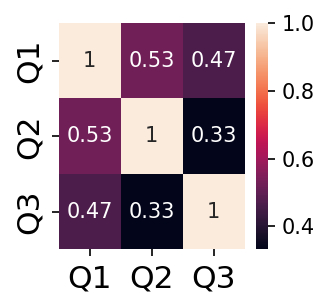

In [8]:
# Correlation between Q1, Q2 and Q3
questions = results[['OUTPUT:q1', 'OUTPUT:q2', 'OUTPUT:q3']]
questions['OUTPUT:q1'] = questions['OUTPUT:q1'].map({True: 1, False: 0})
questions['OUTPUT:q2'] = questions['OUTPUT:q2'].map({True: 1, False: 0})
questions['OUTPUT:q3'] = questions['OUTPUT:q3'].map({True: 1, False: 0})

questions.columns = ['Q1', 'Q2', 'Q3']
corr = questions.corr()
#print(corr)
sn.heatmap(corr, annot=True)
plt.xticks(fontsize=small_fontsize)
plt.yticks(fontsize=small_fontsize)
plt.show()

In [9]:
# Check how often the annotated type matches the type(s) that we have in the dataset (ground truth)
types = results[['INPUT:memelink', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable', 'OUTPUT:result']]
types.rename(columns = {'INPUT:memelink':'url'}, inplace = True)
types = pd.merge(types, memes, on="url", how="left")
types = types[['url', 'type', 'OUTPUT:reaction', 'OUTPUT:snowclone', 'OUTPUT:exploitable', 'OUTPUT:result']]

typematch = []
for target, r, s, e in zip(types['type'], types['OUTPUT:reaction'], types['OUTPUT:snowclone'], types['OUTPUT:exploitable']):
    output = set()
    if r == True:
        output.add("reaction")
    if s == True:
        output.add("snowclone")
    if e == True:
        output.add("exploitable")
    if len(output.intersection(set(target))) > 0:
        typematch.append(1)
    else:
        typematch.append(0)
    
print("Percentage of annotations that got the type right:", sum(typematch) / len(typematch))

Percentage of annotations that got the type right: 0.6


In [10]:
# TODO check agreement between annotators for a meme's type (there are 5 annotations, what percentage of them match? – not sure how to measure)

# Highlights

## General visualizations

In [11]:
# Average length of highlights (overall and per meme?) – for title and for meaning separately

In [12]:
# Average number of highlights (overall and per meme?) – for title and for meaning separately

## Compare highlight similarity: MEANING

### Rank the annotation similarity by standard deviation of NUMBER of annotations

In [13]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Meaning
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Meaning']) if 'Meaning' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (meaning):\n", std_annotations)

Standard deviation of NUMBER of annotations (meaning):
 {'https://knowyourmeme.com/memes/repost-if-x': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/ew-i-stepped-in-shit': 0.0, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 0.0, 'https://knowyourmeme.com/memes/bitches-love-smiley-faces': 0.0, 'https://knowyourmeme.com/memes/modern-society-parodies': 0.0, 'https://knowyourmeme.com/memes/misinformationalized-you-hear-about-video-games': 0.0, 'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/thats-where-youre-wrong-kiddo': 0.0, 'https://knowyourmeme.com/memes/top-gun-hat': 0.4, 'https://knowyourmeme.com/memes/imminent-ned-brace-yourselv

### Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations

In [14]:
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Meaning' in ann.keys():
            for highlight in ann['Meaning']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (meaning):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (meaning):
 {'https://knowyourmeme.com/memes/modern-society-parodies': 4.758150901348127, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 5.427706698044765, 'https://knowyourmeme.com/memes/pennywise-the-clown': 5.782732917920384, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 12.077251342917394, 'https://knowyourmeme.com/memes/your-mother-and-i-will-always-love-you': 17.26962651593832, 'https://knowyourmeme.com/memes/ideal-gf': 18.24938355123263, 'https://knowyourmeme.com/memes/no-items-fox-only-final-destination': 18.30409790183608, 'https://knowyourmeme.com/memes/i-am-altering-the-deal': 18.993098161642237, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 21.30352083576797, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 21.509067855209345, 'https://knowyourmeme.com/memes/oh-no-its-retarded': 21.73844520659194, 'https://knowyourmeme.com/memes/cant-argue-with-that-technicall

### Rank the annotation similarity by Levenshtein distance of annotations

In [15]:
# Assign similarity threshold and consensus percentage
similarity_threshold = 0.2  # If the distance between two annotations is less than this, they are considered a match
consensus_percentage = 0.6  # If at least X% of the pairwise annotation similarities match for a meme, we consider it to have consensus

In [16]:
highlights = {key:[] for key in set(results['INPUT:memelink'])}
distances = {key:{} for key in set(results['INPUT:memelink'])}

# Make dictionary of highlights with IDs
for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Meaning' in ann.keys():
            for a in ann['Meaning']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns

# Calculate distances
for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key].append(dist / max(len(ann1[1]), len(ann2[1])))  # normalize to [0,1], see https://stackoverflow.com/questions/45783385/normalizing-the-edit-distance
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        dist = Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))
                        lev[new_key] = [dist / max(len(ann1[1]), len(ann2[1]))]
    distances[key] = lev
    
# Create flat list with all distances, find max for normalization
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
max_dist = max(hist_data)
       
# Create dictionary with a similarity matrix for each meme
def similarity_matrices(similarity_threshold):
    matrices = {}       
    col_names = ['A1', 'A2', 'A3', 'A4', 'A5']
    for key, value in distances.items():
        columns = {key:[] for key in col_names}
        c = 0
        for k, v in value.items():
            l = [x for x in v if x != -1]
            dist =  min(l) if len(l) > 0 else np.nan
            columns[k[:2]].append(dist)

        # Add np.nan to make matrix complete
        for k in columns.keys():
            for i in range(5 - len(columns[k])):
                columns[k].insert(0, np.nan)

        df = pd.DataFrame(columns, index = col_names)    

        # Mirror bottom values to top
        for i in range(1,6):
            label = 'A' + str(i)
            col = df[label]
            row = df.loc[label]
            new_row = []
            for c, r in zip(col, row):
                if c != np.nan:
                    new_row.append(c)
                else:
                    new_row.append(r)
            df.loc[label] = new_row

        # Change diagonal values to 0
        np.fill_diagonal(df.values, 0)

        # Apply similarity threshold
        df = df.applymap(lambda x: 1 if x < similarity_threshold else 0)

        # Add new row with sum
        df.loc["Total"] = df.sum()

        matrices[key] = df
    return matrices

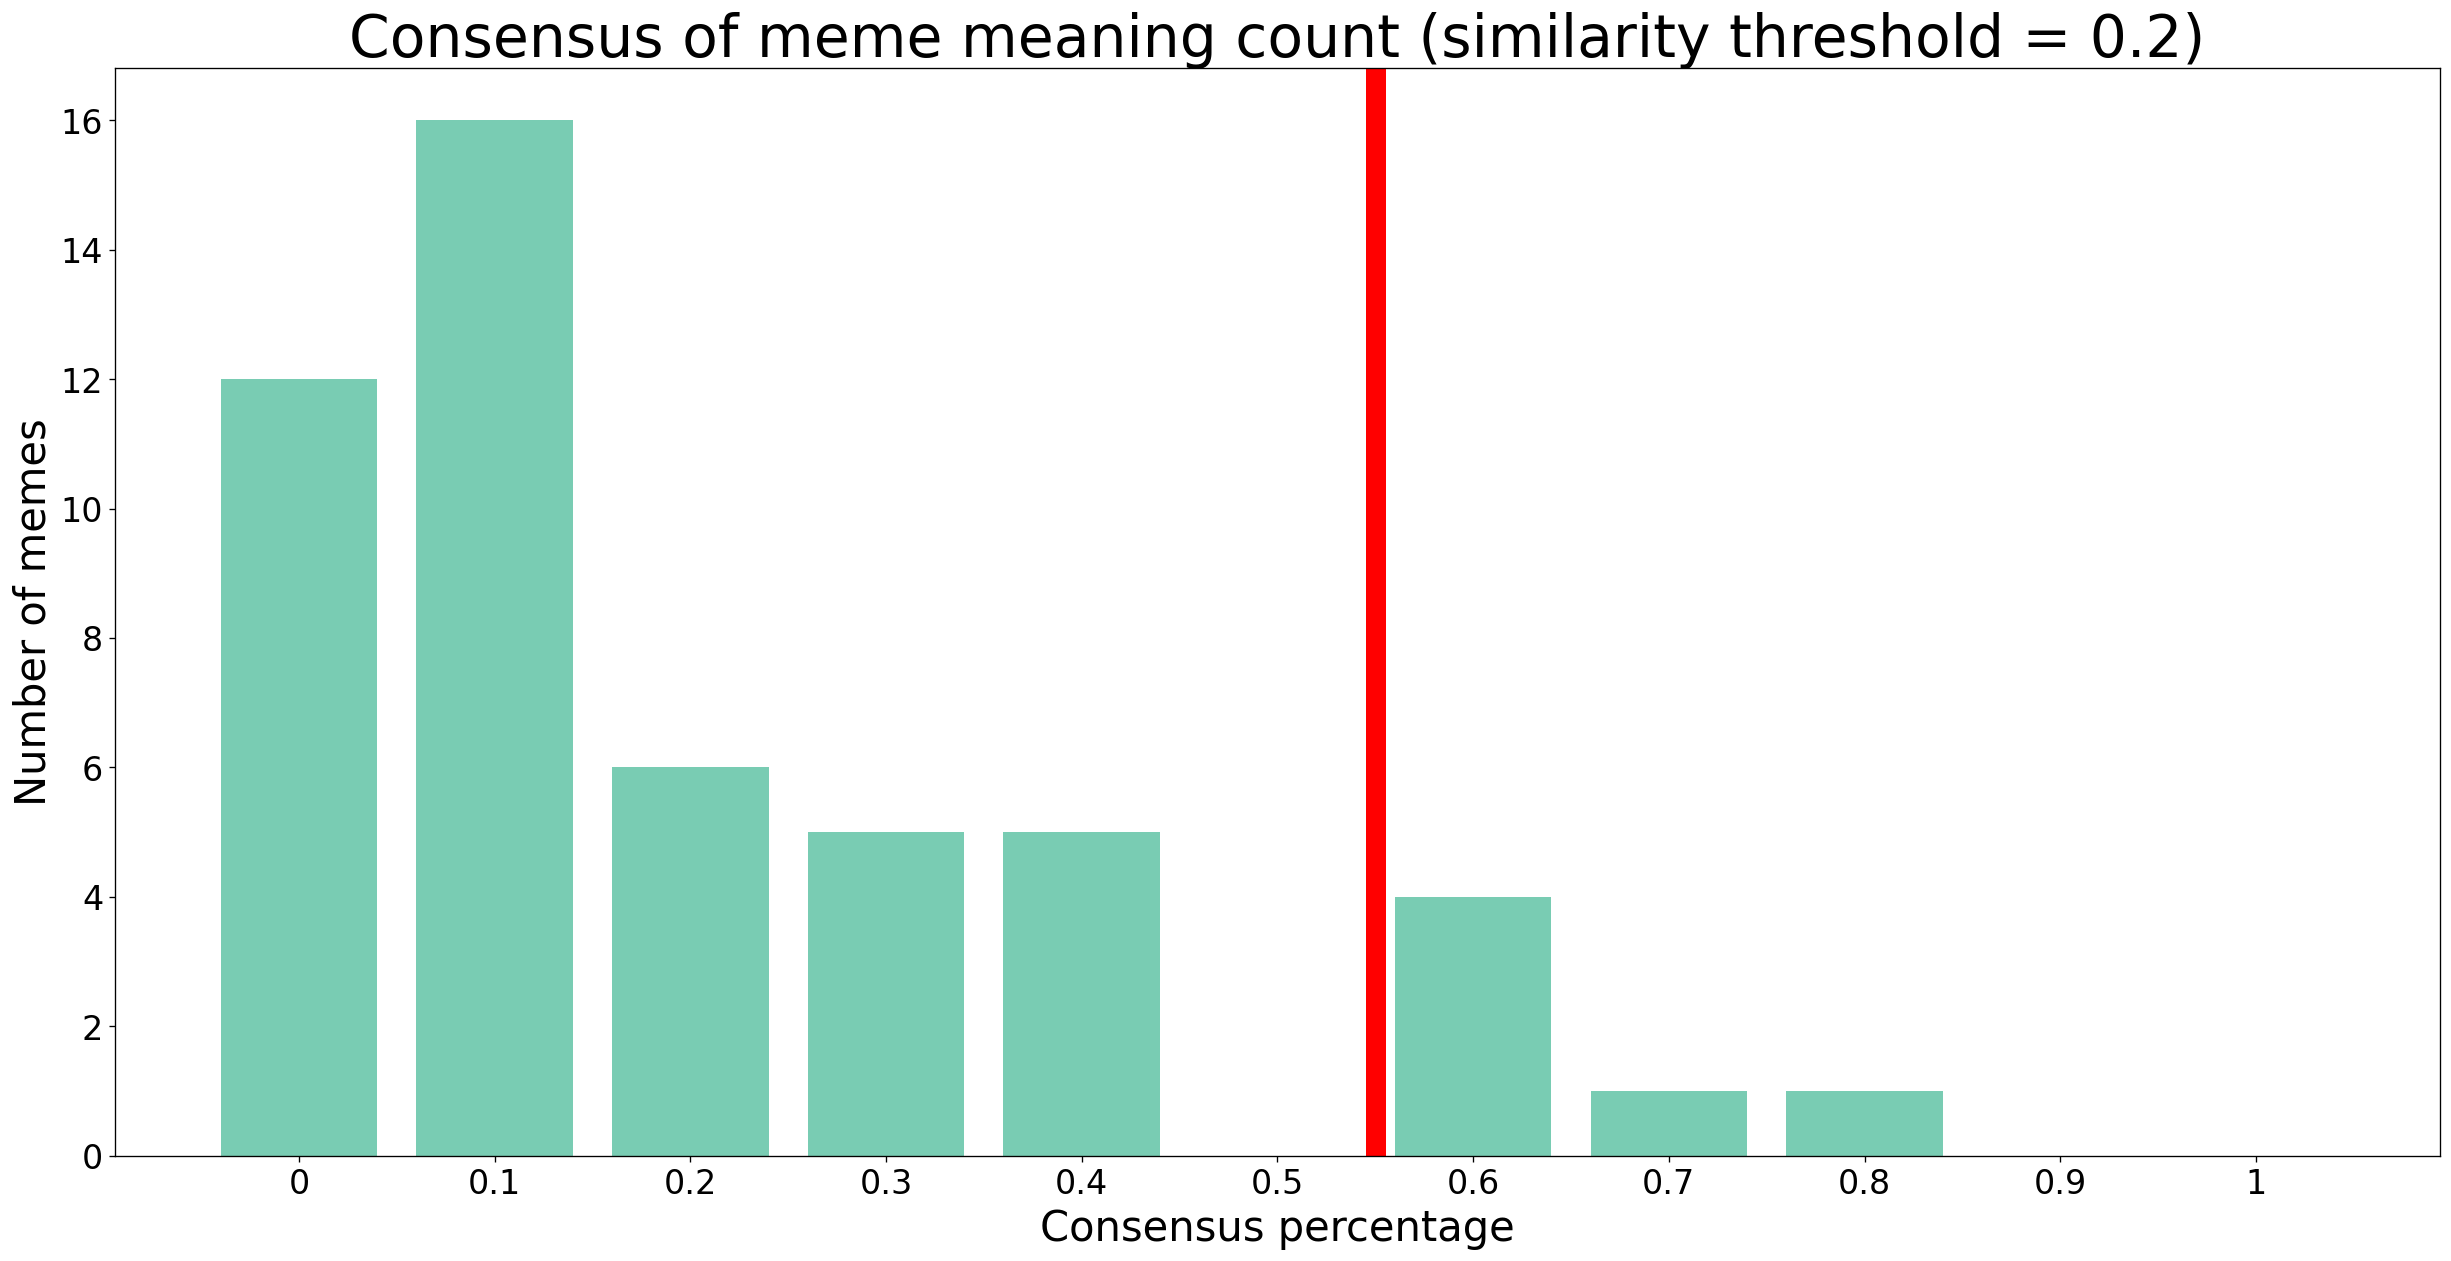

In [17]:
# Function that outputs proportion of pairwise annotation matches
def consensus_level(matrix):
    m_sum = 0
    for i, col in enumerate(matrix.columns):
        row = list(matrix.loc[col])
        m_sum += sum(row[i+1:])
    return m_sum / 10

# Get matrices
matrices = similarity_matrices(0.1)

# Calculate consensus for each meme
consensus_data = {}
for key, m in matrices.items():
    proportion = consensus_level(m)
    consensus_data[key] = proportion
    
# Create Counter
consensus_counter = Counter(consensus_data.values())    
    
# Fill in missing values
for i in np.arange(0, 1.1, 0.1):
    i = round(i,1)
    if i not in consensus_counter.keys():
        consensus_counter[i] = 0

# Sort the data
consensus_counter = dict(sorted(consensus_counter.items(), key=lambda item: item[0], reverse=False))

# Visualize
# TODO WHY IS THIS SO UGLY IN SLACK
plt.figure(figsize=(25, 12), dpi=120)
plt.bar(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'], consensus_counter.values(), color=hex1)
plt.axvline(x=consensus_percentage*10*0.917, color="red", linewidth=12)
plt.ylabel('Number of memes', fontsize=medium_fontsize)
plt.xlabel('Consensus percentage', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Consensus of meme meaning count (similarity threshold = {})".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/consensus.png', bbox_inches='tight')
plt.show() 

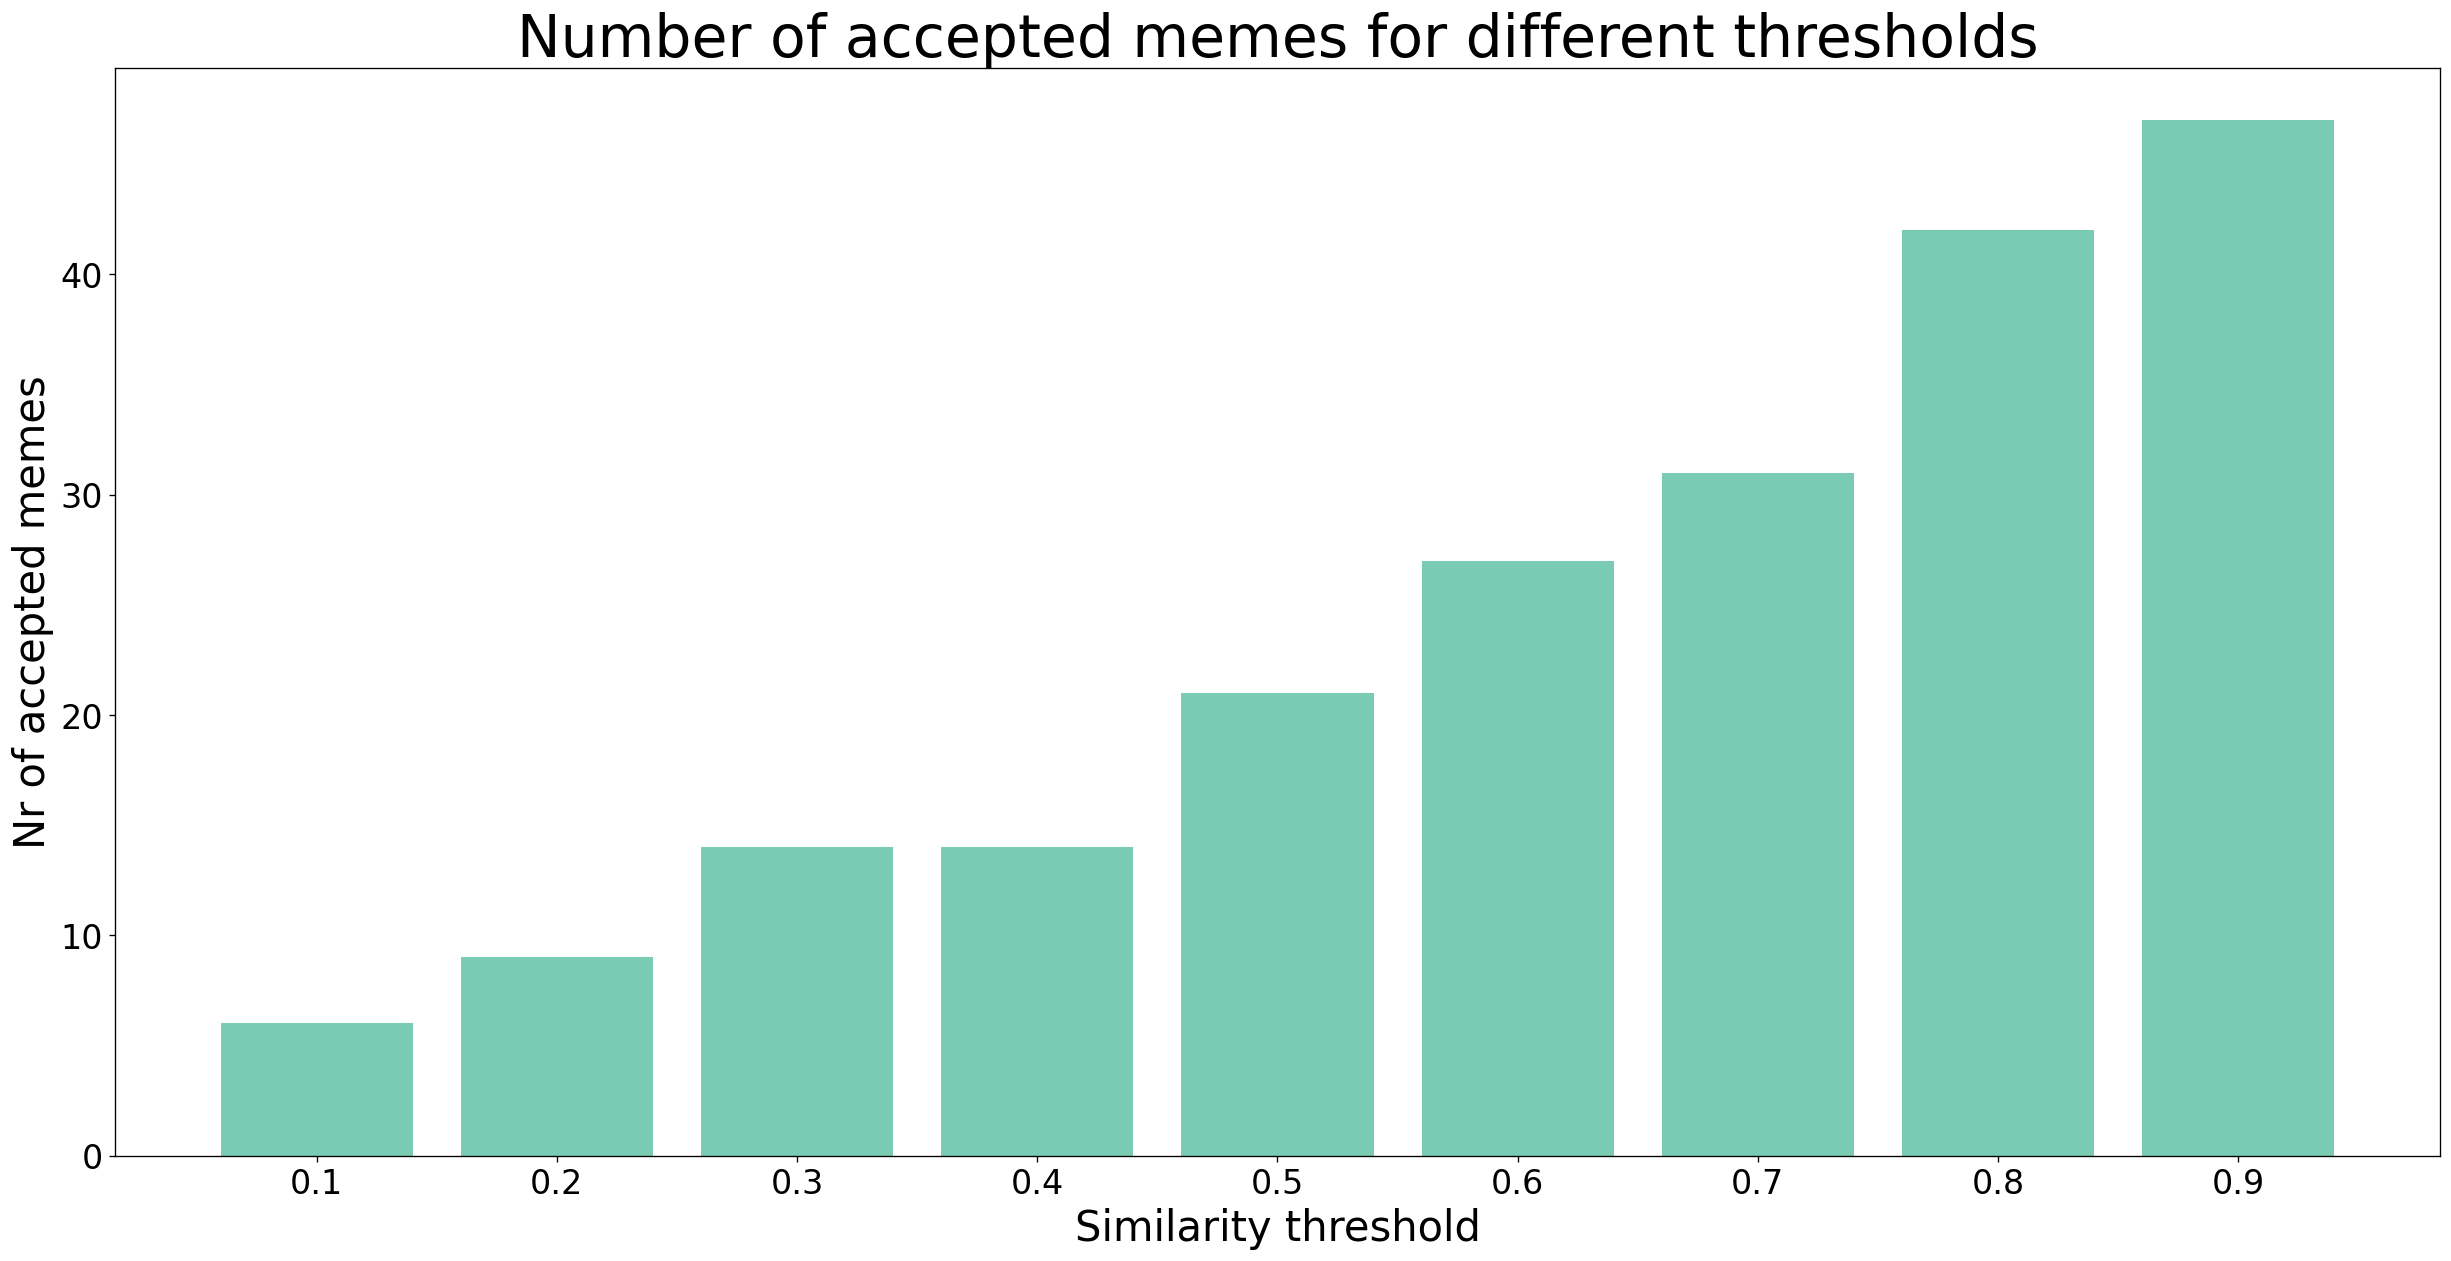

In [18]:
# Plot number of accepted memes for different similarity thresholds
# Function that outputs proportion of pairwise annotation matches

# Get matrices
x_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
y_vals = []

for sim_thresh in x_range:
    matrices = similarity_matrices(sim_thresh)

    # Calculate consensus for each meme
    consensus_data = {}
    for key, m in matrices.items():
        proportion = consensus_level(m)
        consensus_data[key] = proportion

    # Create Counter
    consensus_counter = Counter(consensus_data.values())    

    # Get number of memes that are >= consensus_percentage
    accepted_num = sum([val for key, val in consensus_counter.items() if key >= 0.6])
    y_vals.append(accepted_num)
    

# Visualize
plt.figure(figsize=(25, 12), dpi=120)
plt.bar([str(n) for n in x_range], y_vals, color=hex1)
plt.ylabel('Nr of accepted memes', fontsize=medium_fontsize)
plt.xlabel('Similarity threshold', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
plt.title("Number of accepted memes for different thresholds".format(similarity_threshold), fontsize=large_fontsize)
# plt.savefig('graphs/toloka/similarity_thresholds.png', bbox_inches='tight')
plt.show()

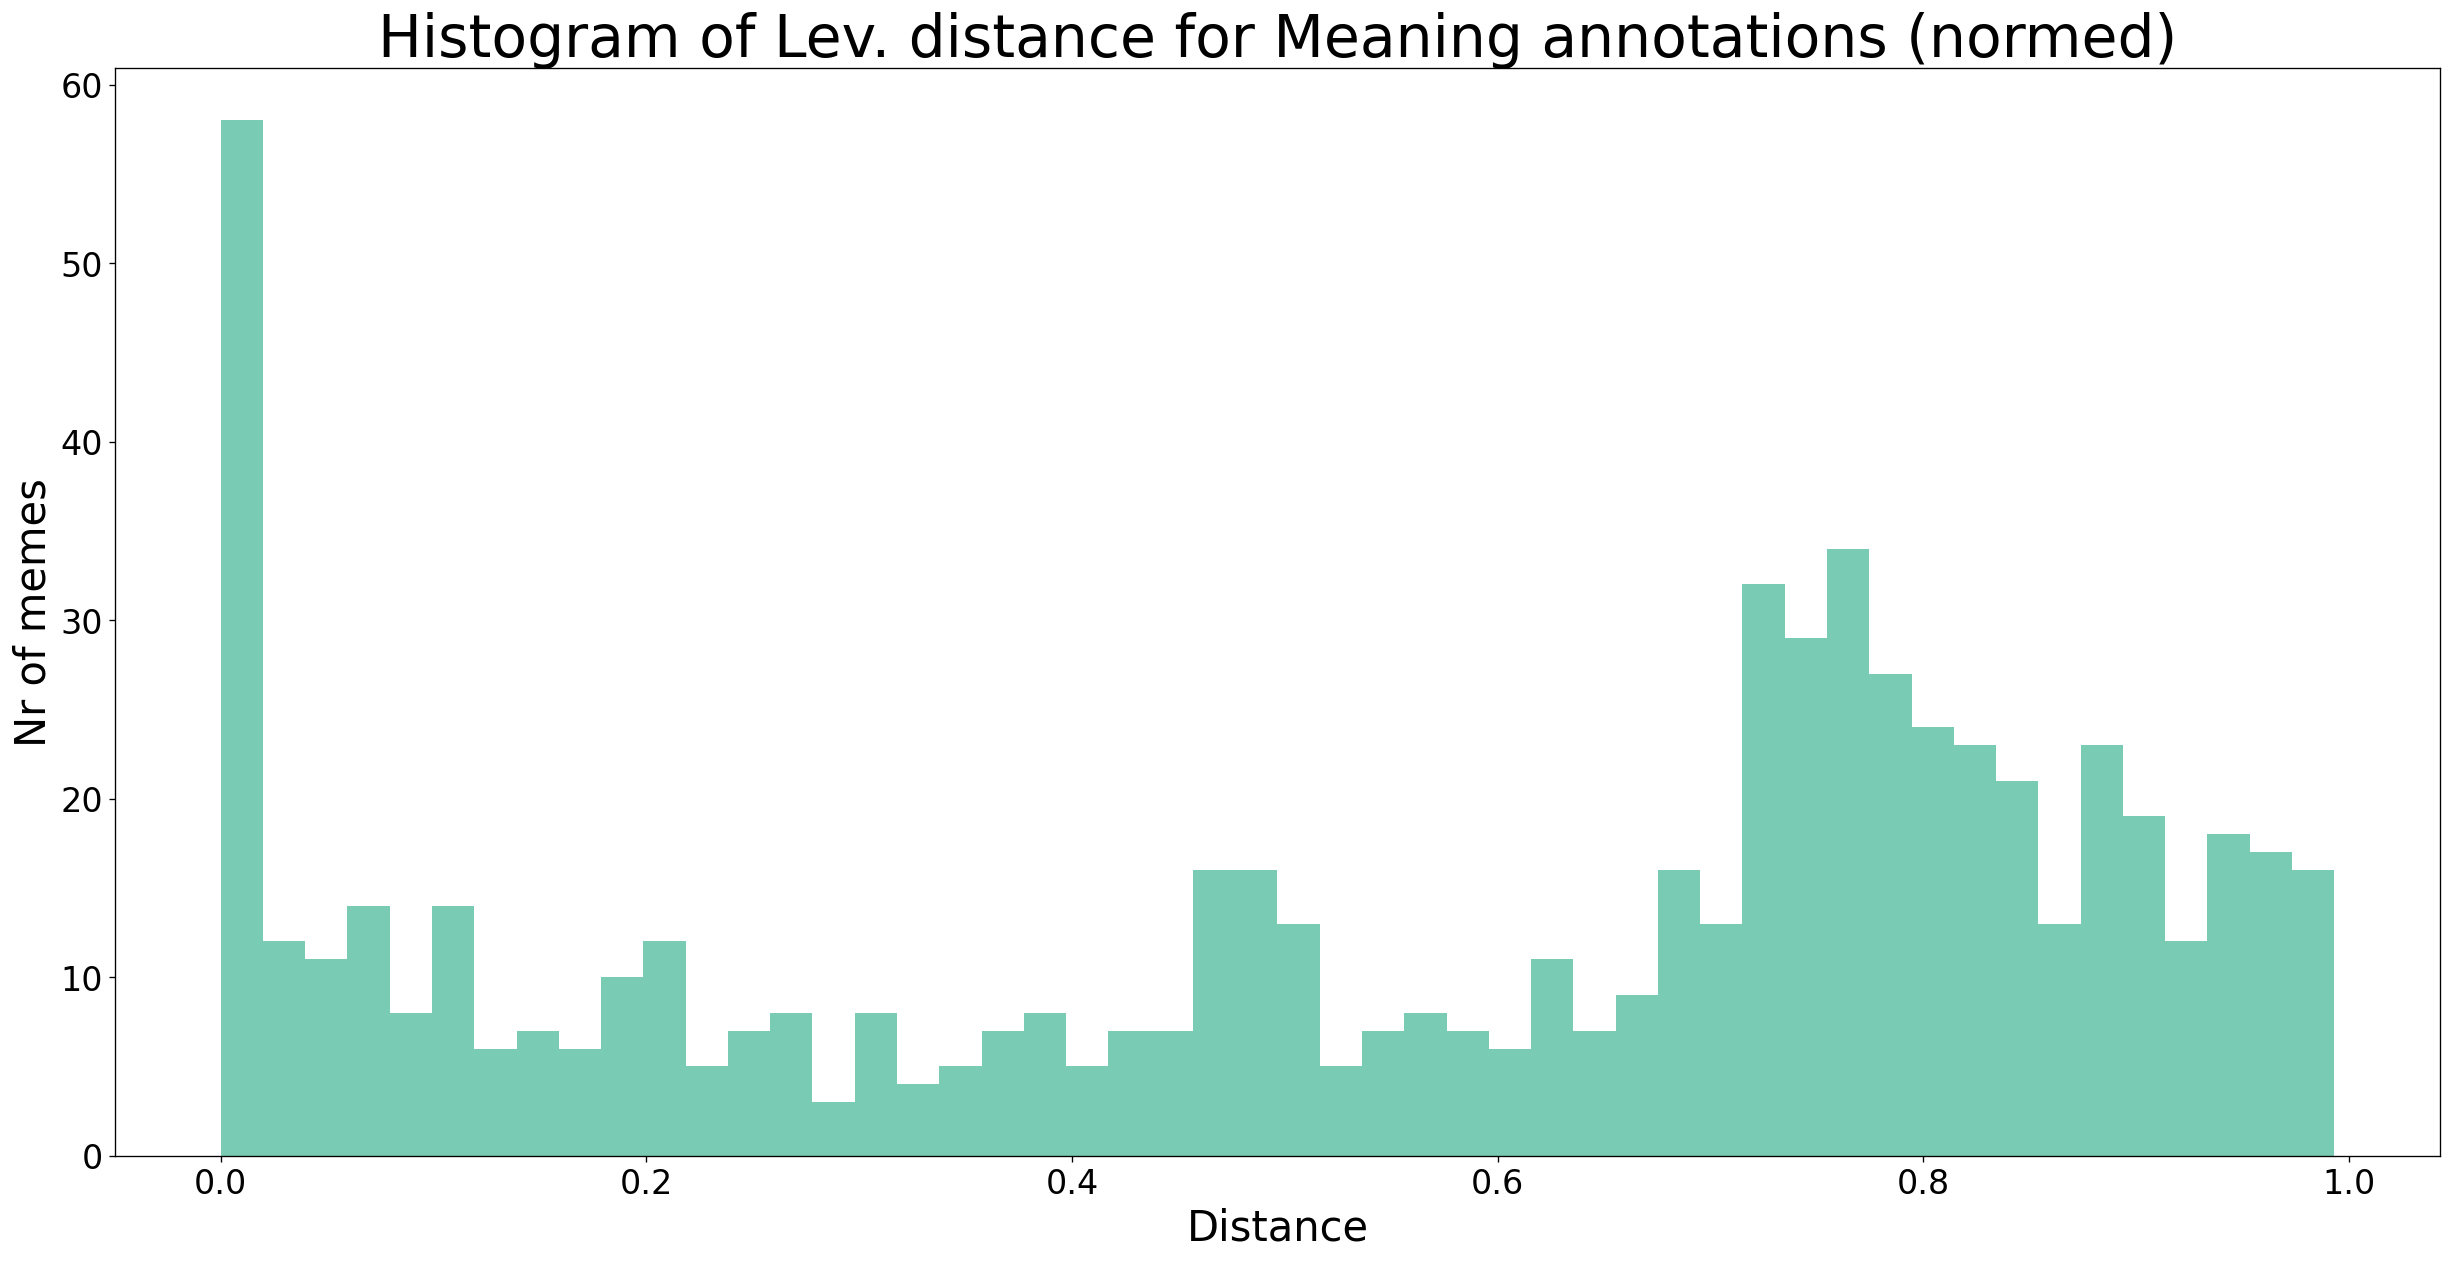

In [19]:
# Plot levenshtein distance histogram
plt.figure(figsize=(25, 12), dpi=120)
plt.hist(hist_data, bins = 50, color=hex1)
plt.title("Histogram of Lev. distance for Meaning annotations (normed)", fontsize=large_fontsize)
plt.ylabel('Nr of memes', fontsize=medium_fontsize)
plt.xlabel('Distance', fontsize=medium_fontsize)
plt.xticks(fontsize=small_fontsize+5)
plt.yticks(fontsize=small_fontsize+5)
# plt.savefig('graphs/toloka/meaning_dist_histogram.png', bbox_inches='tight')
plt.show() 

In [22]:
# Boxplot for distances


distances_per_meme = {key:[dist for dist_list in val.values() for dist in dist_list if dist >= 0] for key, val in distances.items()}
"""
plt.figure(figsize=(15,5))
c = 0

data = distances_per_meme.values()
positions = np.arange(1, 51, step=1)
#labels = [str(i) for i in range(1,51)]
plt.boxplot(data, positions=positions, showfliers=True)
#axis[i][j].set_title(title.split("/")[-1][:30])#, fontsize=large_fontsize)
plt.title('Distance boxplots')
plt.ylabel('Distance')
plt.xlabel('Meme')
plt.xticks(np.arange(1, 51, step=1))
#plt.yticks([])
c += 1
# plt.savefig('graphs/toloka/boxplots_oneplot.png', pad_inches=2.5)
plt.show() 
"""

'\nplt.figure(figsize=(15,5))\nc = 0\n\ndata = distances_per_meme.values()\npositions = np.arange(1, 51, step=1)\n#labels = [str(i) for i in range(1,51)]\nplt.boxplot(data, positions=positions, showfliers=True)\n#axis[i][j].set_title(title.split("/")[-1][:30])#, fontsize=large_fontsize)\nplt.title(\'Distance boxplots\')\nplt.ylabel(\'Distance\')\nplt.xlabel(\'Meme\')\nplt.xticks(np.arange(1, 51, step=1))\n#plt.yticks([])\nc += 1\n# plt.savefig(\'graphs/toloka/boxplots_oneplot.png\', pad_inches=2.5)\nplt.show() \n'

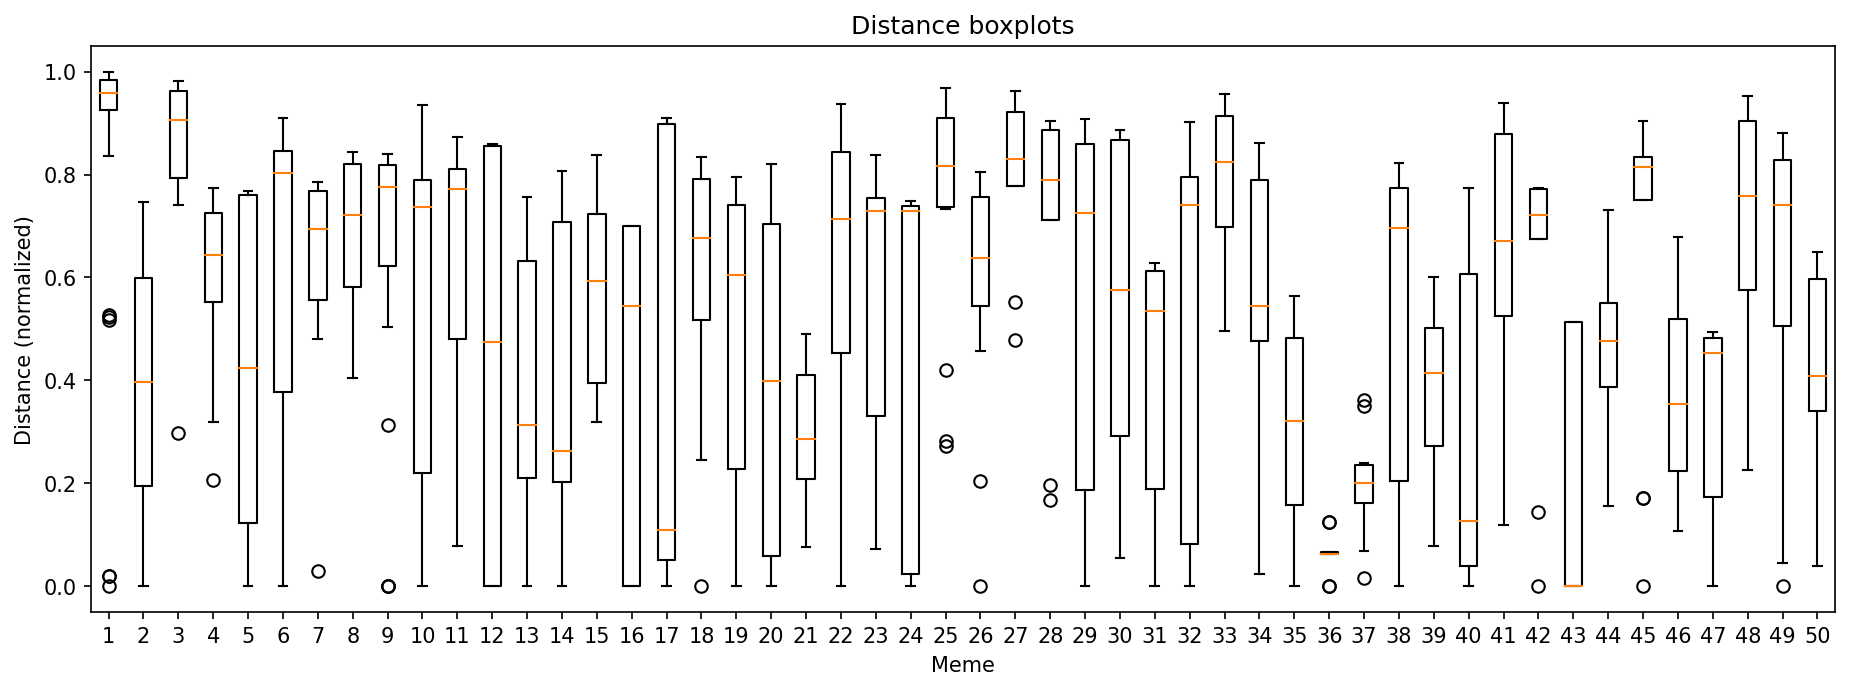

In [23]:
# Boxplot for similarity – all in one (normalized)
import copy
plt.figure(figsize=(15,5))
c = 0
dist_copy = copy.deepcopy(distances_per_meme)
data = list(dist_copy.values())
for i in range(len(data)):
    for j in range(len(data[i])):
        data[i][j] = data[i][j] / max_dist
positions = np.arange(1, 51, step=1)
#labels = [str(i) for i in range(1,51)]
plt.boxplot(data, positions=positions, showfliers=True)
#axis[i][j].set_title(title.split("/")[-1][:30])#, fontsize=large_fontsize)
plt.title('Distance boxplots')
plt.ylabel('Distance (normalized)')
plt.xlabel('Meme')
plt.xticks(np.arange(1, 51, step=1))
#plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.yticks([])
c += 1
# plt.savefig('graphs/toloka/boxplots_oneplot_norm.png', pad_inches=2.5)
plt.show() 

In [24]:
distances_per_meme = list(distances_per_meme)
distances_per_meme[8]
highlights['https://knowyourmeme.com/memes/talk-to-me-like-youre-a-fucking-idiot']

[(1,
  'an exploitable webcomic by Cyanide and Happiness in which a woman asks her partner to talk to her like "a fucking idiot" during intercourse. Variations of the comic are typically used to mock opposing viewpoints and political beliefs in a similar vein to the "Oh No, It\'s Retarded" series.'),
 (2, 'mock opposing viewpoints and political beliefs'),
 (3,
  'typically used to mock opposing viewpoints and political beliefs in a similar'),
 (4,
  'a woman asks her partner to talk to her like "a fucking idiot" during intercourse'),
 (4,
  'used to mock opposing viewpoints and political beliefs in a similar vein to the "Oh No, It\'s Retarded" series'),
 (5, '')]

In [27]:
highlights[distances_per_meme[36]]

[(1,
  'a phrasal template or snowclone, captioning an image of a fictional character performing the activity, expressing that one cannot be true fan of said field without knowledge of the image subject.'),
 (2,
  'character performing the activity, expressing that one cannot be true fan of said field without knowledge of the image subject.'),
 (3,
  'an image of a fictional character performing the activity, expressing that one cannot be true fan of said field without knowledge of the image subject.'),
 (4,
  'captioning an image of a fictional character performing the activity, expressing that one cannot be true fan of said field without knowledge of the image subject.'),
 (5,
  'is a phrasal template or snowclone, captioning an image of a fictional character performing the activity, expressing that one cannot be true fan of said field without knowledge of the image subject.')]

## Compare highlight similarity: TITLE

In [24]:
annotations = {key:[] for key in set(results['INPUT:memelink'])}
for url, highlights in zip(results['INPUT:memelink'], results['OUTPUT:result']):
    annotations[url].append(highlights)

# Number of annotations for Title
num_annotations = {key:[] for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    num_annotations[key] = [len(x['Title']) if 'Title' in x.keys() else 0 for x in val]

# Rank the annotation similarity by standard deviation of NUMBER of annotations
std_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in num_annotations.items():
    std_annotations[key] = np.std(val)
std_annotations = dict(sorted(std_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of NUMBER of annotations (title):\n", std_annotations)

Standard deviation of NUMBER of annotations (title):
 {'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/oh-you-love-x-name-every-y': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/modern-society-parodies': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/i-see-dead-people': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 0.0, 'https://knowyourmeme.com/memes/does-he-bite': 0.0, 'https://knowyourmeme.com/memes/4-panel-cringe': 0.0, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https:

In [25]:
# Rank the annotation similarity by standard deviation of AVERAGE LENGTH of annotations
length_annotations = {key:0 for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    avg_lengths = []
    for ann in val:
        avg = []
        if 'Title' in ann.keys():
            for highlight in ann['Title']:
                avg.append(len(highlight))
            avg_lengths.append(sum(avg) / len(avg))
        else:
            avg_lengths.append(0)
    length_annotations[key] = np.std(avg_lengths)
    
length_annotations = dict(sorted(length_annotations.items(), key=lambda item: item[1]))
print("Standard deviation of AVERAGE LENGTH of annotations (title):\n", length_annotations)

Standard deviation of AVERAGE LENGTH of annotations (title):
 {'https://knowyourmeme.com/memes/pennywise-the-clown': 0.0, 'https://knowyourmeme.com/memes/darth-vaders-i-find-your-lack-of-faith-disturbing': 0.0, 'https://knowyourmeme.com/memes/the-deathbulge-party-saga': 0.0, 'https://knowyourmeme.com/memes/i-was-only-pretending-to-be-retarded': 0.0, 'https://knowyourmeme.com/memes/is-this-a-pigeon': 0.0, 'https://knowyourmeme.com/memes/dont-say-youre-a-fan-if-you-dont-know-who-this-is': 0.0, 'https://knowyourmeme.com/memes/cant-argue-with-that-technically-not-wrong': 0.0, 'https://knowyourmeme.com/memes/4-panel-cringe': 0.0, 'https://knowyourmeme.com/memes/how-to-talk-to-short-people': 0.0, 'https://knowyourmeme.com/memes/coincidence-i-think-not': 0.0, 'https://knowyourmeme.com/memes/running-dad': 0.0, 'https://knowyourmeme.com/memes/ideal-gf': 0.0, 'https://knowyourmeme.com/memes/yall-consider-this-a-date': 0.0, 'https://knowyourmeme.com/memes/swear-jar': 0.0, 'https://knowyourmeme.co

In [26]:
# Rank the annotation similarity by Levenshtein distance of annotations
highlights = {key:[] for key in set(results['INPUT:memelink'])}
distances = {key:{} for key in set(results['INPUT:memelink'])}
for key, val in annotations.items():
    ID = 0
    anns = []
    for ann in val:
        ID += 1
        if 'Title' in ann.keys():
            for a in ann['Title']:
                anns.append((ID, a))
        else:
            anns.append((ID, "")) # Missing annotations
    highlights[key] = anns


for key, val in highlights.items():
    lev = {}
    for i in range(len(val) - 1):
        for j in range(i + 1, len(val)):
            ann1 = val[i]
            ann2 = val[j]
            if ann1[0] != ann2[0]:
                new_key = "A" + str(ann1[0]) + "-A" + str(ann2[0])
                if new_key in lev.keys():
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key].append(-1)
                    else:
                        lev[new_key].append(Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-")))
                else:
                    if ann1[1] == "" or ann2[1] == "":
                        lev[new_key] = [-1]
                    else:
                        lev[new_key] = [Levenshtein.distance(ann1[1].strip(" ,.:;-"), ann2[1].strip(" ,.:;-"))]
    distances[key] = lev
            

col_names = ['url', 'A1-A2', 'A1-A3', 'A1-A4', 'A1-A5', 'A2-A3', 'A2-A4', 'A2-A5', 'A3-A4', 'A3-A5', 'A4-A5']
columns = {key:[] for key in col_names}

for key, value in distances.items():
    columns['url'].append(key)
    for k, v in value.items():
        columns[k].append([x for x in v if x != -1])  # Remove missing values

df = pd.DataFrame(columns)
df.head(10)

,url,A1-A2,A1-A3,A1-A4,A1-A5,A2-A3,A2-A4,A2-A5,A3-A4,A3-A5,A4-A5
0,https://knowyourmeme.com/memes/top-gun-hat,"[0, 5]",[0],"[0, 5]",[0],"[0, 5]","[0, 5, 5, 0]","[0, 5]","[0, 5]",[0],"[0, 5]"
1,https://knowyourmeme.com/memes/pennywise-the-c...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
2,https://knowyourmeme.com/memes/oh-you-love-x-n...,"[0, 28, 28, 0]","[0, 28, 28, 0]","[27, 36, 15, 12]","[0, 28, 28, 0]","[0, 28, 28, 0]","[27, 36, 15, 12]","[0, 28, 28, 0]","[27, 36, 15, 12]","[0, 28, 28, 0]","[27, 15, 36, 12]"
3,https://knowyourmeme.com/memes/autistic-screec...,"[0, 4]","[0, 4]","[0, 4]","[0, 4]",[0],[0],[0],[0],[0],[0]
4,https://knowyourmeme.com/memes/disappointed-bl...,[0],"[17, 19]",[0],[0],"[17, 19]",[0],[0],"[17, 19]","[17, 19]",[0]
5,https://knowyourmeme.com/memes/darth-vaders-i-...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
6,https://knowyourmeme.com/memes/modern-society-...,[9],[0],[9],[9],[9],[0],[0],[9],[9],[0]
7,https://knowyourmeme.com/memes/the-deathbulge-...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
8,https://knowyourmeme.com/memes/i-was-only-pret...,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]
9,https://knowyourmeme.com/memes/is-this-a-pigeon,[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]


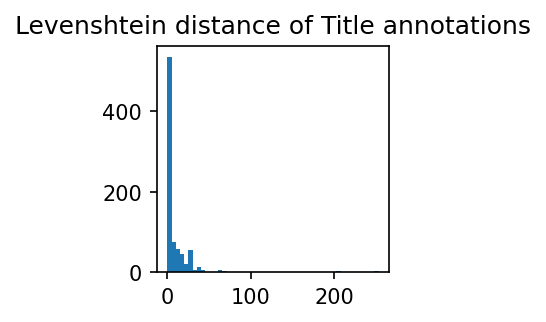

In [27]:
# Plot levenshtein distance histogram
hist_data = [x for val in distances.values() for x in val.values()]
hist_data = [x for sublist in hist_data for x in sublist if x != -1]
plt.hist(hist_data, bins = 50)
plt.title("Levenshtein distance of Title annotations")
plt.show() 

## Compare Label Studio vs Toloka labelling similarity

In [28]:
# Read in and clean data
studio = pd.read_json("data/label_studio.json")
studio = studio[['annotations', 'data']]

# Add url as column
studio['url'] = [data['url'] for data in studio['data']]
studio = studio.drop(columns=['data'])

# Retrieve highlights from Label Studio JSON
highlights = {}
for url, ann in zip(studio['url'], studio['annotations']):
    info = {"Title":[], "Meaning":[], "Type":[]}
    for label in ann[0]['result']:    
        text = label['value']['text']
        category = label['value']['labels'][0]
        if category in ["Meme", "Meaning", "MemeType"]:
            if category == "Meme":
                category = "Title"
            elif category == "MemeType":
                category = "Type"
            info[category].append(text)
    if url in highlights.keys() and len(highlights[url]['Meaning']) >= len(info['Meaning']):  # Some memes are annotated multiple times
        continue
    highlights[url] = info

# Add new column with Label Studio highlights
labelstudio_col = [highlights[url] for url in types['url']]
types['labelstudio'] = labelstudio_col
types.head()

,url,type,OUTPUT:reaction,OUTPUT:snowclone,OUTPUT:exploitable,OUTPUT:result,labelstudio
0,https://knowyourmeme.com/memes/autistic-screec...,[exploitable],False,True,False,"{'Title': ['Autistic Screeching', '""autistic s...","{'Title': ['Autistic Screeching'], 'Meaning': ..."
1,https://knowyourmeme.com/memes/no-items-fox-on...,"[pop-culture-reference, snowclone]",True,False,False,"{'Title': ['No Items, Fox Only, Final Destinat...","{'Title': ['No Items, Fox Only, Final Destinat..."
2,https://knowyourmeme.com/memes/lie-down-try-no...,[exploitable],True,False,False,"{'Title': ['Lie Down', 'Try Not to Cry', 'Cry ...",{'Title': ['Lie Down / Try Not to Cry / Cry a ...
3,https://knowyourmeme.com/memes/autistic-screec...,[exploitable],True,False,False,"{'Title': ['Autistic Screeching'], 'Meaning': ...","{'Title': ['Autistic Screeching'], 'Meaning': ..."
4,https://knowyourmeme.com/memes/yall-consider-t...,[snowclone],False,False,True,"{'Title': ['Y'all Consider This A Date?'], 'Me...","{'Title': ['Y'all Consider This A Date?'], 'Me..."
